In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import torch 

from DEPO.depo import depo_best
from utils.model import load_checkpoint
from utils.metrics import mAA, rotation_angle_distance_batch, vector_angle_distance_batch, mAA_max, mAA_sep

from data.seven_scenes.utils_7scenes import SevenScenesEvalDataset
from training.seven_scenes_eval import test
from torch.utils.data import DataLoader
from pathlib import Path

import numpy as np
from numpy.linalg import norm

import pickle
import os.path as osp
from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 0. Data

In [133]:
pairs = pd.read_csv('/home/project/data/7scenes/NN_7scenes.txt', header=None, sep=' ')

absent = []

for i in tqdm(range(pairs.shape[0])):
    
    scenes_dicitionary = {
            0: 'chess', 
            1: 'fire',
            2: 'heads',
            3: 'office',
            4: 'pumpkin',
            5: 'redkitchen',
            6: 'stairs'} 
    
    name_0 = osp.join('/home/project/data/7scenes/', scenes_dicitionary[pairs.iloc[i][2]], pairs.iloc[i][0][1:])
    name_1 = osp.join('/home/project/data/7scenes/', scenes_dicitionary[pairs.iloc[i][2]], pairs.iloc[i][1][1:])
    
    if (not Path(name_0).is_file()) or (not Path(name_1).is_file()):
        absent.append(i)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85000/85000 [00:23<00:00, 3604.19it/s]


In [141]:
pairs.drop(absent, axis=0, inplace=True) #problems in heads sequence

In [142]:
pairs.to_csv('/home/project/data/7scenes/NN_7_scenes_corrected.txt', header=False, index=False, sep=' ')

### 1.1 DEPO-C-f: PVT-L + QT-B + Spatial pred. (final), without FT

In [10]:
metrics_before_ft = {}

if Path('/home/project/code/results/7scenes/metrics_before_ft').is_file():
    with open('/home/project/code/results/7scenes/metrics_before_ft', 'rb') as f:
        metrics_before_ft = pickle.load(f)

In [9]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/flow_and_pose_best_abs_0.pth',
    device)

In [10]:
model = depo_best(calculate_flow=False)
model.load_state_dict(checkpoint['model'])
model.to(device);

In [145]:
scenes = {
    'chess': 0,
    'fire' : 1,
    'heads': 2,
    'office': 3,
    'pumpkin': 4,
    'redkitchen': 5,
    'stairs': 6
}   

for scene_name, scene_id in scenes.items():
    test_data = SevenScenesEvalDataset(root_dir='/home/project/data/7scenes',
                                       pairs_path='/home/project/data/7scenes/NN_7_scenes_corrected.txt', scene=scene_id)
    test_loader = DataLoader(test_data, batch_size=8, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)
    results = test(model, test_loader, device)
    
    metrics_before_ft[scene_name] = {
        'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
        't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
        't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
        'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
        't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
    }

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 585/585 [02:15<00:00,  4.31it/s]


### Saving metrics

In [170]:
with open('/home/project/code/results/7scenes/metrics_before_ft', 'wb') as f:
    pickle.dump(metrics_before_ft, f)

### 1.2 DEPO-C-f: PVT-L + QT-B + Spatial pred. (final), FT


In [5]:
metrics_with_ft = {}

if Path('/home/project/code/results/7scenes/metrics_with_ft').is_file():
    with open('/home/project/code/results/7scenes/metrics_with_ft', 'rb') as f:
        metrics_with_ft = pickle.load(f)

In [6]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/7_scenes_ft_pretrained_10.pth',
    device)

In [7]:
model = depo_best(calculate_flow=False)
model.load_state_dict(checkpoint['model'])
model.to(device);

In [10]:
scenes = {
    'chess': 0,
    'fire' : 1,
    'heads': 2,
    'office': 3,
    'pumpkin': 4,
    'redkitchen': 5,
    'stairs': 6
}   

for scene_name, scene_id in scenes.items():
    test_data = SevenScenesEvalDataset(root_dir='/home/project/data/7scenes',
                                       pairs_path='/home/project/data/7scenes/NN_7_scenes_corrected.txt', scene=scene_id)
    test_loader = DataLoader(test_data, batch_size=8, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)
    results = test(model, test_loader, device)
    
    metrics_with_ft[scene_name] = {
        'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
        't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
        't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
        'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
        't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
    }

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:27<00:00,  4.23it/s]


### Saving metrics

In [11]:
with open('/home/project/code/results/7scenes/metrics_with_ft', 'wb') as f:
    pickle.dump(metrics_with_ft, f)

### 1.3 DEPO-C-f: PVT-L + QT-B + Spatial pred. (final), reinit


In [11]:
metrics_reinit = {}

if Path('/home/project/code/results/7scenes/metrics_reinit').is_file():
    with open('/home/project/code/results/7scenes/metrics_reinit', 'rb') as f:
        metrics_reinit = pickle.load(f)

In [22]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/7_scenes_ft_reinit_19.pth',
    device)

In [23]:
model = depo_best(calculate_flow=False)
model.load_state_dict(checkpoint['model'])
model.to(device);

In [24]:
scenes = {
    'chess': 0,
    'fire' : 1,
    'heads': 2,
    'office': 3,
    'pumpkin': 4,
    'redkitchen': 5,
    'stairs': 6
}   

for scene_name, scene_id in scenes.items():
    test_data = SevenScenesEvalDataset(root_dir='/home/project/data/7scenes',
                                       pairs_path='/home/project/data/7scenes/NN_7_scenes_corrected.txt', scene=scene_id)
    test_loader = DataLoader(test_data, batch_size=8, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)
    results = test(model, test_loader, device)
    
    metrics_reinit[scene_name] = {
        'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
        't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
        't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
        'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
        't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
    }

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:27<00:00,  4.23it/s]


### Saving metrics

In [25]:
with open('/home/project/code/results/7scenes/metrics_reinit', 'wb') as f:
    pickle.dump(metrics_reinit, f)

### 1.4 DEPO-C-f: PVT-L + QT-B + Spatial pred. (final), FT-15


In [5]:
metrics_with_ft_15 = {}

if Path('/home/project/code/results/7scenes/metrics_with_ft_15').is_file():
    with open('/home/project/code/results/7scenes/metrics_with_ft_15', 'rb') as f:
        metrics_with_ft_15 = pickle.load(f)

In [6]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/7_scenes_ft_pretrained_20_14.pth',
    device)

In [7]:
model = depo_best(calculate_flow=False)
model.load_state_dict(checkpoint['model'])
model.to(device);

In [8]:
scenes = {
    'chess': 0,
    'fire' : 1,
    'heads': 2,
    'office': 3,
    'pumpkin': 4,
    'redkitchen': 5,
    'stairs': 6
}   

for scene_name, scene_id in scenes.items():
    test_data = SevenScenesEvalDataset(root_dir='/home/project/data/7scenes',
                                       pairs_path='/home/project/data/7scenes/NN_7_scenes_corrected.txt', scene=scene_id)
    test_loader = DataLoader(test_data, batch_size=8, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)
    results = test(model, test_loader, device)
    
    metrics_with_ft_15[scene_name] = {
        'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
        't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
        't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
        'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
        't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
    }

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:29<00:00,  4.17it/s]


### Saving metrics

In [9]:
with open('/home/project/code/results/7scenes/metrics_with_ft_15', 'wb') as f:
    pickle.dump(metrics_with_ft_15, f)

## 2. Table form

In [36]:
df = {
    ('Method', 1): [None],
    ('Chess', '$R_e^{0.5}$'): None,
    ('Chess', '$t_e^{0.5}$'): None,
    ('Fire', '$R_e^{0.5}$'): None,
    ('Fire', '$t_e^{0.5}$'): None,
    ('Heads', '$R_e^{0.5}$'): None,
    ('Heads', '$t_e^{0.5}$'): None,
    ('Office', '$R_e^{0.5}$'): None,
    ('Office', '$t_e^{0.5}$'): None,
    ('Pumpkin', '$R_e^{0.5}$'): None,
    ('Pumpkin', '$t_e^{0.5}$'): None,
    ('Redkitchen', '$R_e^{0.5}$'): None,
    ('Redkitchen', '$t_e^{0.5}$'): None,
    ('Stairs', '$R_e^{0.5}$'): None,
    ('Stairs', '$t_e^{0.5}$'): None,
    ('Average', '$R_e^{0.5}$'): None,
    ('Average', '$t_e^{0.5}$'): None,
}


df = pd.DataFrame(df)

df.columns = pd.MultiIndex.from_tuples(df.columns)

df.loc[0] = ['RelPoseNet [2017]\cite{laskar2017camera}', 8.149, 0.261, 12.327, 0.382, 12.414, 0.234, 9.045, 0.307, 9.362, 0.352, 9.636, 0.407, 12.259, 0.367, 10.456, 0.342]
df.loc[1] = ['8Point [2022]\cite{rockwell20228}', 3.338, 0.123, 7.819, 0.270, 10.384, 0.172, 4.059, 0.181, 3.682, 0.187, 4.145, 0.210, 5.018, 0.263, 5.492, 0.214]
df.loc[2] = ['Map-free rep. [2022]\cite{arnold2022map}', 5.835, 0.154, 12.207, 0.334, 12.542, 0.191, 7.319, 0.237, 6.647, 0.269, 7.093, 0.267, 10.167, 0.313, 8.830, 0.268]
df.loc[3] = ['Map-free Scannet [2022]\cite{arnold2022map}', 5.445, 0.144, 5.110, 0.149, 3.406, 0.112, 3.518, 0.13, 5.506, 0.266, 3.754, 0.185, 3.817, 0.152, 4.365, 0.166]
df.loc[4] = ['GRelPose [2022]\cite{khatib2022grelpose}', 4.463, 0.147, 7.206, 0.195, 7.254, 0.128, 4.653, 0.167, 4.797, 0.225, 4.543, 0.203, 5.840, 0.238, 5.537, 0.186]
df.loc[5] = ['GRelPose-Scannet [2022]\cite{khatib2022grelpose}', 3.568, 0.115, 4.946, 0.142, 6.195, 0.123, 3.660, 0.140, 3.670, 0.168, 4.019, 0.149, 6.344, 0.225, 4.630, 0.158]


# w/o FT
i=6
df.loc[i] = None
df.loc[i]['Method'] = 'DEPO-C-f, w/o FT'
total_t = []
total_r = []
for key, val in metrics_before_ft.items():
    total_t.append(val["t_distances_l2"])
    total_r.append(val["R_angle_distances"])
    df.loc[i, (key.capitalize(), '$t_e^{0.5}$')] = np.median(val["t_distances_l2"])
    df.loc[i, (key.capitalize(), '$R_e^{0.5}$')] = np.median(val["R_angle_distances"])
total_t = np.concatenate(total_t)
total_r = np.concatenate(total_r)
# df.loc[i, ('Average', '$t_e^{0.5}$')] = np.median(total_t)
# df.loc[i, ('Average', '$R_e^{0.5}$')] = np.median(total_r)
df.loc[i, ('Average', '$R_e^{0.5}$')] = df.iloc[i, 1:-2:2].mean()
df.loc[i, ('Average', '$t_e^{0.5}$')] = df.iloc[i, 2:-2:2].mean()


# with FT
i=7
df.loc[i] = None
df.loc[i]['Method'] = 'DEPO-C-f, with FT'
total_t = []
total_r = []
for key, val in metrics_with_ft_15.items():
    total_t.append(val["t_distances_l2"])
    total_r.append(val["R_angle_distances"])
    df.loc[i, (key.capitalize(), '$t_e^{0.5}$')] = np.median(val["t_distances_l2"])
    df.loc[i, (key.capitalize(), '$R_e^{0.5}$')] = np.median(val["R_angle_distances"])
total_t = np.concatenate(total_t)
total_r = np.concatenate(total_r)
# df.loc[i, ('Average', '$t_e^{0.5}$')] = np.median(total_t)
# df.loc[i, ('Average', '$R_e^{0.5}$')] = np.median(total_r)
df.loc[i, ('Average', '$R_e^{0.5}$')] = df.iloc[i, 1:-2:2].mean()
df.loc[i, ('Average', '$t_e^{0.5}$')] = df.iloc[i, 2:-2:2].mean()



#with reinit
i=8
df.loc[i] = None
df.loc[i]['Method'] = 'DEPO-C-f, reinit'
total_t = []
total_r = []
for key, val in metrics_reinit.items():
    total_t.append(val["t_distances_l2"])
    total_r.append(val["R_angle_distances"])
    df.loc[i, (key.capitalize(), '$t_e^{0.5}$')] = np.median(val["t_distances_l2"])
    df.loc[i, (key.capitalize(), '$R_e^{0.5}$')] = np.median(val["R_angle_distances"])
total_t = np.concatenate(total_t)
total_r = np.concatenate(total_r)
# df.loc[i, ('Average', '$t_e^{0.5}$')] = np.median(total_t)
# df.loc[i, ('Average', '$R_e^{0.5}$')] = np.median(total_r)
df.loc[i, ('Average', '$R_e^{0.5}$')] = df.iloc[i, 1:-2:2].mean()
df.loc[i, ('Average', '$t_e^{0.5}$')] = df.iloc[i, 2:-2:2].mean()




df.iloc[:, 1:] = df.iloc[:, 1:].astype('float32')
df.set_index('Method', inplace=True)
df.index = df.index.map(lambda x: x[0])


d = df.style.format(precision=3)
d.background_gradient(cmap="RdYlGn_r", axis=0)
d.highlight_min(color='blue')

d.index.names = [None]

d.to_latex(
    buf='/home/project/code/results/paper/tab_6_seven_scenes.tex',
    position='h!',
    position_float='centering',
    sparse_index=True,
    multicol_align='c',
    convert_css=True,
    caption='Relative pose estimation on 7 Scenes',
    label='tab:7scenes',
    hrules=True,
    clines='skip-last;data'
)
d

/tmp/ipykernel_54297/429801532.py:36: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[i] = None
/tmp/ipykernel_54297/429801532.py:55: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[i] = None
/tmp/ipykernel_54297/429801532.py:75: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[i] = None
/tmp/ipykernel_54297/429801532.py:94: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, 1:] = df.iloc[:, 1:].ast

In [35]:
df.loc['DEPO-C-f, with FT'][:-2][::2].min(), df.loc['DEPO-C-f, with FT'][:-2][::2].max()
df.loc['DEPO-C-f, with FT'][:-2][1::2].min(), df.loc['DEPO-C-f, with FT'][:-2][1::2].max()

(0.11721103, 0.25630617)

In [20]:
metrics = {}

# w/o ft
all_metrics_ = {}
for scene, m in metrics_before_ft.items():
    for metric_name, metric_values in m.items():
        all_metrics_.setdefault(metric_name, []).append(metric_values)

all_metrics = {}
for metric_name, metric_values in all_metrics_.items():
    all_metrics[metric_name] = np.concatenate(metric_values)
metrics['DEPO-C-f: w/o FT'] = all_metrics    

# with f/t
all_metrics_ = {}
for scene, m in metrics_with_ft_15.items():
    for metric_name, metric_values in m.items():
        all_metrics_.setdefault(metric_name, []).append(metric_values)

all_metrics = {}
for metric_name, metric_values in all_metrics_.items():
    all_metrics[metric_name] = np.concatenate(metric_values)
metrics['DEPO-C-f: with FT'] = all_metrics

# with reinit
all_metrics_ = {}
for scene, m in metrics_reinit.items():
    for metric_name, metric_values in m.items():
        all_metrics_.setdefault(metric_name, []).append(metric_values)

all_metrics = {}
for metric_name, metric_values in all_metrics_.items():
    all_metrics[metric_name] = np.concatenate(metric_values)
metrics['DEPO-C-f: with reinit'] = all_metrics



In [21]:
rc('text', usetex=True)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

rc('font', size=MEDIUM_SIZE)          # controls default text sizes
rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [23]:
def calculate_metric_on_subset(metric_values, values_dependent_on, agg_func, thresholds, sign):
    thresholds_ = thresholds[:, None]
    if sign == '>':
        inliers_bool = values_dependent_on > thresholds_
    else:
        inliers_bool = values_dependent_on <= thresholds_
    scores = np.array([agg_func(metric_values[subset]) for subset in inliers_bool])
    return scores

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


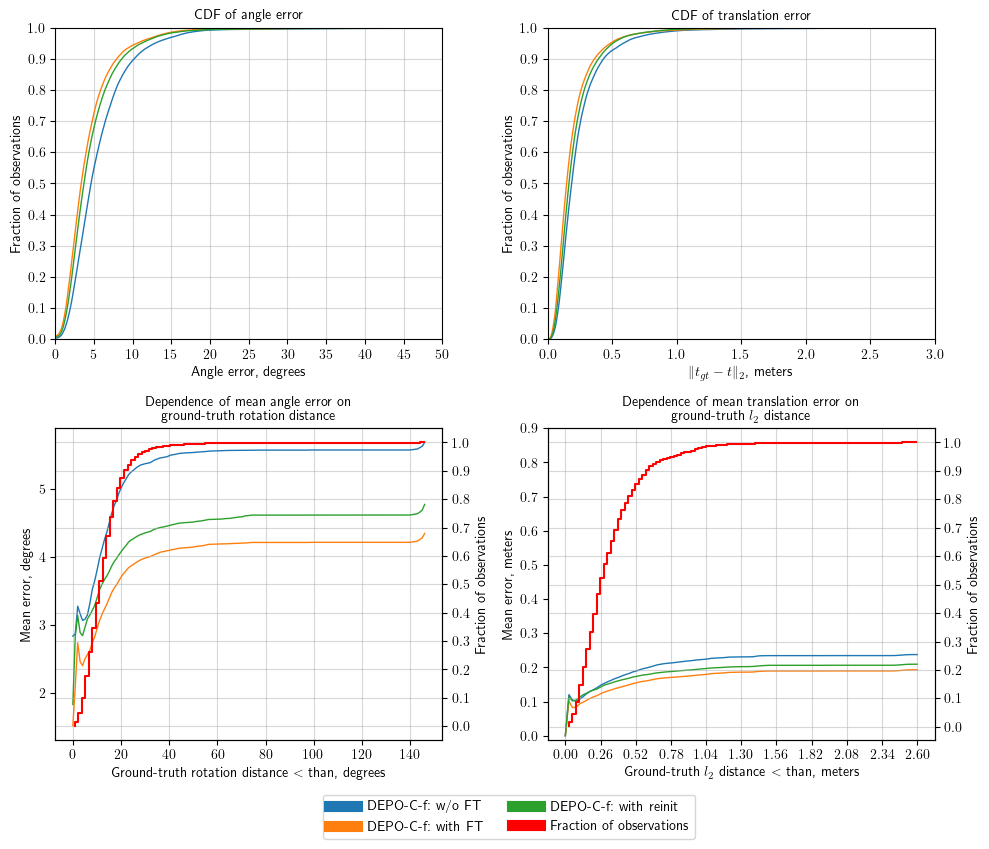

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#F08080', 
          '#87CEFA', '#FF6347', '#3CB371', '#FFA07A', '#FFD700',
          '#F0E68C', '#FF69B4', '#BA55D3', '#87CEEB']


exp_colors = {exp: col for  exp, col in zip(metrics.keys(), colors)}

for exp, m in metrics.items():
    sns.ecdfplot(x=m['R_angle_distances'], complementary=False, ax=ax[0,0], c=exp_colors[exp], linewidth=1)    

    sns.ecdfplot(x=m['t_distances_l2'], complementary=False, ax=ax[0,1], c=exp_colors[exp], linewidth=1, log_scale=False)

    R_on_gt = calculate_metric_on_subset(
        m['R_angle_distances'], m['R_gt_distances'], np.mean, np.linspace(0, 146, 146), '<')
    R_on_gt[np.isnan(R_on_gt)] = 0
    ax[1, 0].plot(np.linspace(0, 146, 146), R_on_gt, label=exp, c=exp_colors[exp], linewidth=1)
    
    t_on_gt = calculate_metric_on_subset(
        m['t_distances_l2'], m['t_gt_distances'], np.mean, np.linspace(0, 2.6, 100), '<')
    t_on_gt[np.isnan(t_on_gt)] = 0
    ax[1, 1].plot(np.linspace(0, 2.6, 100), t_on_gt, c=exp_colors[exp], linewidth=1)

    
    
ax[0, 0].set_xlim([0., 50.])
ax[0, 0].set_xticks(np.linspace(0, 50, 11, dtype='int'))
ax[0, 0].set_yticks(np.linspace(0, 1, 11))
ax[0, 0].set_ylabel('Fraction of observations')
ax[0, 0].set_xlabel('Angle error, degrees')
ax[0, 0].set_title('CDF of angle error')
ax[0, 0].grid(alpha=0.5)


ax[0, 1].set_xlim([0., 3.])
ax[0, 1].set_yticks(np.linspace(0, 1, 11))
ax[0, 1].set_ylabel('Fraction of observations')
ax[0, 1].set_xlabel('$\|t_{gt} - t\|_2$, meters')
ax[0, 1].set_title('CDF of translation error')
ax[0, 1].grid(alpha=0.5)


n_bins = 100 # number of bins for histogram calculation 
counts, bin_edges = np.histogram(np.sort(m['R_gt_distances']), bins=n_bins)
cdf_values = np.cumsum(counts) / len(m['R_gt_distances'])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
ax_10 = ax[1, 0].twinx() # create secondary axis with shared x-axis  
ax_10.step(bin_centers,cdf_values,'r', label='Fraction of observations')
ax_10.set_ylabel('Fraction of observations')
ax_10.set_yticks(np.linspace(0, 1, 11))
ax_10.grid(alpha=0.5)
ax[1, 0].set_xlabel('Ground-truth rotation distance $<$ than, degrees')
ax[1, 0].set_ylabel('Mean error, degrees')
ax[1, 0].set_title('Dependence of mean angle error on \n ground-truth rotation distance')
ax[1, 0].grid(axis='x', alpha=0.5)

n_bins = 100 # number of bins for histogram calculation 
counts, bin_edges = np.histogram(np.sort(m['t_gt_distances']), bins=n_bins)
cdf_values = np.cumsum(counts) / len(m['t_gt_distances'])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
ax_11 = ax[1, 1].twinx() # create secondary axis with shared x-axis  
ax_11.step(bin_centers, cdf_values, 'r', label='Fraction of observations')
ax_11.set_ylabel('Fraction of observations')
ax_11.set_yticks(np.linspace(0, 1, 11))
ax_11.grid(alpha=0.5)
ax[1, 1].set_xticks(np.linspace(0, 2.6, 11))
ax[1, 1].set_yticks(np.linspace(0, 0.9, 10))
ax[1, 1].set_xlabel('Ground-truth $l_2$ distance $<$ than, meters')
ax[1, 1].set_ylabel('Mean error, meters')
ax[1, 1].set_title('Dependence of mean translation error on \n ground-truth $l_2$ distance')
ax[1, 1].grid(axis='x', alpha=0.5)

handles, labels = ax[1, 0].get_legend_handles_labels()

handles.extend(ax_11.get_legend_handles_labels()[0])
labels.extend(ax_11.get_legend_handles_labels()[1])

from copy import copy
handles_ = [copy(ha) for ha in handles]
for h in handles_:
    h.set_linewidth(8)

fig.legend(handles_, labels, bbox_to_anchor=(.7, 0), borderaxespad=0.0, ncol=2)



fig.tight_layout()
plt.savefig('/home/project/code/results/paper/fig_2_cdfs_7scenes.pdf', bbox_inches='tight')